#Assignment 1:
    test if the distribution of ages is the same for 
    
    1) male and femal riders
    
    2) day and night riders
    
    use 3 tests: KS, Pearson's, Spearman's

my usual imports and setups

In [2]:
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline

import os

#this makes my plots pretty! but it is totally not mandatory to do it
import json
# s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
# pl.rcParams.update(s)


Populating the interactive namespace from numpy and matplotlib


I am reading in data from January 2015. It would be a good idea to use data from warmer months, since there are more riders in the warm weather and the more data the smaller the STATISTICAL NOISE. If you are ambitios you can use data from multiple months, thus addressing systematic errors as well

In [3]:
# df=pd.read_csv(os.getenv ('PUI2015')+'/notebooks/data/201501-citibike-tripdata.csv')
df=pd.read_csv('201502-citibike-tripdata.csv', parse_dates=['starttime'])
print df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')


#BY GENDER
splitting data by gender and extracting the age happens in the cell below

In [5]:
#df is the dataframe where the content of the csv file is stored
df['ageM'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 1)]
df['ageF'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 2)]

lets splot age in 10 year bins. the dataset is very large, so i could be split in smaller bins, but I will chose 10 years in the interest of time. if i was to do this "for real" the bin size choice should be a balance between properly sample the age space, have enough counts in each bin that the statistical noise is not significant (remember that is > sqrt(N)!) and the computational requirement to computatinal facilities ratio. 

the next several steps are needed if you want to code up the KS test from scratch. that is for extra credit, so if you do not want to do it you may not need to plot split the distribution in bins and create the cumulative HOWEVER it is a great idea to do it anyways to explore your data viaually! remember Ascombe's quartet!!

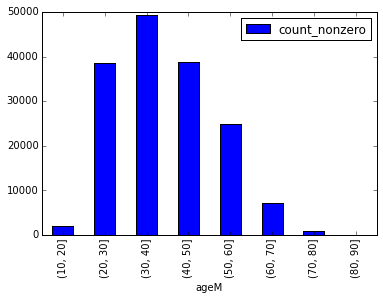

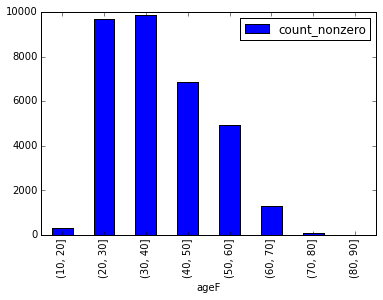

In [6]:
bins = np.arange(10, 99, 10)
df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).plot(kind='bar')
df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).plot(kind='bar')

this is how the cumulative distributions look like.  Notice that i am normalizing them! if i want to reat an observed distribution like a probablility distribution i have to normalize it

          count_nonzero
ageM                   
(10, 20]       0.002160
(20, 30]       0.052312
(30, 40]       0.044676
(40, 50]       0.012573
(50, 60]       0.008436
(60, 70]       0.003543
(70, 80]       0.000207
(80, 90]       0.000000


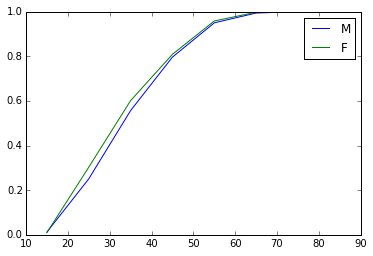

In [7]:
#print df.ageS, df.ageS.cumsum()

csM=df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).cumsum()

csF=df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).cumsum()

print np.abs(csM / csM.max()-csF / csF.max())

pl.plot(bins[:-1] + 5, csM / csM.max(), label = "M")
pl.plot(bins[:-1] + 5, csF / csF.max(), label = "F")
pl.legend()

they look pretty darn similar! that sets my expectation for the tests to come. if i wanted to code the KS test by hand i woud have everything i need: the normalized cumulative distributions can be subtracted from each other and the max distance can be seeked. 

Notice that there amay be Nan values you are gonna have to deal with! you can do that for example with a Boolean statementsuch as  df.ageF[~np.isnan(df.ageF)] or you can use numpy functions that deal with Nan values: nansum, nanmean, nanstd...

lets run the scipy KS test

In [8]:
import scipy.stats

#KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html


In [9]:
ks=scipy.stats.ks_2samp(df.ageM, df.ageF)
print ks

Ks_2sampResult(statistic=0.65250088864063371, pvalue=0.0)


remember: the Null hypothesis is rejected if 

$D_KS(n1,n2) > c(\alpha) \sqrt{\frac{(n1+n2)}{n1n2}}$

where $c(\alpha$) is the inverse of the KS distribution, and you do not have to know how to get that cause there are tables that list critical values!! 

http://www.real-statistics.com/tests-normality-and-symmetry/statistical-tests-normality-symmetry/kolmogorov-smirnov-test/kolmogorov-distribution/

but scipy is already giving you the p-value, s you do not have to worry about it i am still giving you the table FWI and if you want to do the coding of the KS test by hand


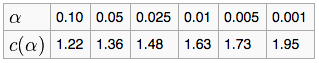

In [10]:
#here is the critical values tablel. Have you chosen your significance level yet?? you should do it first thing!
from IPython.display import Image
Image(filename="ks2sample_table.png")

In [12]:
##this cell is for you to tell me what the scipy KS test returned and what it means
# we fail to reject the Null hypothesis
n1 = df.ageM[~np.isnan(df.ageM)].count()
n2 = df.ageF[~np.isnan(df.ageF)].count()
print n1, n2
# for 0.05 significance level
calpha = 1.36 
calphan1n2 = 1.0 * calpha * sqrt((n1+n2)*1.0/(n1*n2))

def report_result(ks,calphan1n2):
    print 'is the ks value {0:.2f} greater than the critical value {1:.2f}? '.format(ks,calphan1n2)
    if ks>calphan1n2:
        print "Yes!"
    else: print "No!"
    
    print 'the Null hypothesis is {}'.format( 'rejected. Two samples are not drawn from the same continuous distribution.' if ks>calphan1n2  else 'not rejected. Two samples are drawn from the same continuous distribution.') 
    
report_result(ks.statistic,calphan1n2)

161561 33064
is the ks value 0.65 greater than the critical value 0.02? 
Yes!
the Null hypothesis is rejected. Two samples are not drawn from the same continuous distribution.


#Pearson's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr



In [13]:
#please perform the Pearson's test and tell me what you find

ageM = df.ageM[~np.isnan(df.ageM)]
ageF = df.ageF[~np.isnan(df.ageF)]
# print ageM.count()
# print ageF.count()

if ageM.count() != ageF.count():
    if ageM.count() > ageF.count():
        rows = np.random.choice(ageM.index.values, ageF.count())
        ageM = ageM.ix[rows]
    else:
        rows = np.random.choice(ageF.index.values, ageM.count())
        ageF = ageF.ix[rows]

# print ageM.count()
pearsont = scipy.stats.pearsonr(ageM, ageF)
print pearsont

print "Since Pearson’s correlation coefficient is close to 0, there is no linear relationship"

(0.0034705153828280461, 0.5280146847553977)
Since Pearson’s correlation coefficient is close to 0, there is no linear relationship


#Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

In [14]:
from scipy.stats import spearmanr
#please perform the Spearman's test and tell me what you find
spearmanstest = spearmanr(ageM, ageF,axis=0)
print spearmanstest

SpearmanrResult(correlation=0.0048213354169799405, pvalue=0.38067138780976606)


##please comment on the numbers that you get in the light of the scipy manual: what is rerutned? what does it mean??

##DO THE SAME FOR THE DISTRIBUTION OF RIDERS DURING THE DAY VS DURING THE NIGHT!

hint: remember how I converted the starttime last time in my own citibikes notebook into units that are easy to read. 
df['mystarttime'] = ...
then you can use something like
df['mystarttime'].dt.hour

In [24]:

# I selected febraury. 
# Sunrise was approximatially around 6.0 am in febraury 2015
# Sunset was approximatially around 6.0 pm in febraury 2015

#df is the dataframe where the content of the csv file is stored
df['ageD'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['starttime'].dt.hour >= 6) & (df['starttime'].dt.hour <= 18)]
ageD = df.ageD[~np.isnan(df.ageD)]

df['ageN'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & ((df['starttime'].dt.hour <= 6) | (df['starttime'].dt.hour >= 18))]
ageN = df.ageN[~np.isnan(df.ageN)]


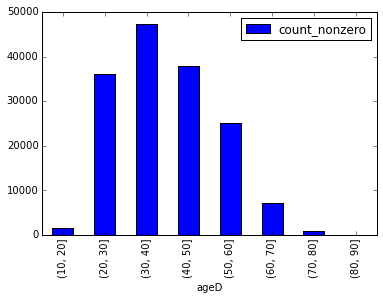

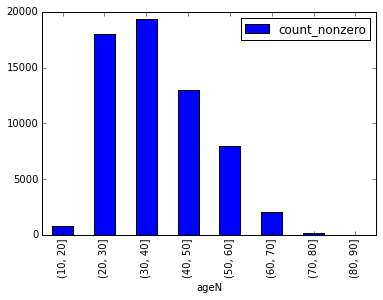

In [25]:
bins = np.arange(10, 99, 10)
ageD.groupby(pd.cut(ageD, bins)).agg([count_nonzero]).plot(kind='bar')
ageN.groupby(pd.cut(ageN, bins)).agg([count_nonzero]).plot(kind='bar')

          count_nonzero
ageD                   
(10, 20]       0.001794
(20, 30]       0.064450
(30, 40]       0.077689
(40, 50]       0.045864
(50, 60]       0.014951
(60, 70]       0.002387
(70, 80]       0.000028
(80, 90]       0.000000


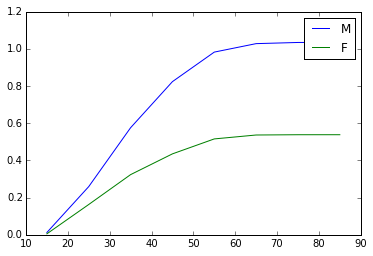

In [26]:
#print df.ageS, df.ageS.cumsum()

csD=ageD.groupby(pd.cut(ageD, bins)).agg([count_nonzero]).cumsum()

csN=ageN.groupby(pd.cut(ageN, bins)).agg([count_nonzero]).cumsum()

print np.abs(csD / csD.max()-csN / csN.max())

pl.plot(bins[:-1] + 5, csM / csD.max(), label = "M")
pl.plot(bins[:-1] + 5, csF / csN.max(), label = "F")
pl.legend()

In [27]:
ks=scipy.stats.ks_2samp(ageD, ageN)
print ks

Ks_2sampResult(statistic=0.084966081153647899, pvalue=2.4444806502658188e-277)


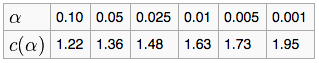

In [28]:
from IPython.display import Image
Image(filename="ks2sample_table.png")

# KS tests to compare 2 samples

In [29]:
n1 = ageD.count()
n2 = ageN.count()
print n1, n2
# for 0.05 significance level
calpha = 1.36 
calphan1n2 = calpha * sqrt((n1+n2)*1.0/(n1*n2))

report_result(ks.statistic,calphan1n2)

156179 61472
is the ks value 0.08 greater than the critical value 0.02? 
Yes!
the Null hypothesis is rejected. Two samples are not drawn from the same continuous distribution.


# Pearson's test for correlation

In [30]:
#please perform the Pearson's test and tell me what you find
# print ageD.count()
# print ageN.count()

# print ageD.index.values
if ageD.count() != ageN.count():
    if ageD.count() > ageN.count():
        rows = np.random.choice(ageD.index.values, ageN.count())
        ageD = ageD.ix[rows]
    else:
        rows = np.random.choice(ageN.index.values, ageD.count())
        ageN = ageN.ix[rows]

# print ageDR.count()
# print ageN.count()

pearsont = scipy.stats.pearsonr(ageD, ageN)
print pearsont

# print "Since Pearson’s correlation coefficient is close to 0, there is no linear relationship"

(-0.006427330026138425, 0.11103749318218115)


# Spearman's test for correlation# 

In [31]:
from scipy.stats import spearmanr
#please perform the Spearman's test and tell me what you find
spearmanstest = spearmanr(ageM, ageF,axis=0)
print spearmanstest

SpearmanrResult(correlation=0.0048213354169799405, pvalue=0.38067138780976606)
